03/28/2022

Useful Resources:
1. Nature Clustering Paper: https://www.nature.com/articles/s41598-022-06559-z.pdf
2. Determining Number of Clusters: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.587.3517&rep=rep1&type=pdf
3. Quantum Qubits Algorithm Clustering: https://arxiv.org/abs/1909.12183
4. Neural Network Compression: https://arxiv.org/abs/2108.12659 
5. How to Include Anomaly Detection: https://arxiv.org/abs/2201.05748?context=cs 
6. Analysis of Efficiency of K-Means: https://ieeexplore.ieee.org/abstract/document/1017616 
7. Fun: A K-Means from Scratch: https://www.machinelearningplus.com/predictive-modeling/k-means-clustering/ 
8. QUBO Wikipedia: https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization
9. Sklearn K-Means: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html



In [ ]:
!pip install pyqubo
!pip install docplex
!pip install cplex

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import docplex.mp.model as md
from pyqubo import Array
import neal
import time
import docplex.mp.model as md
import random
import numpy as np
from matplotlib import cm
from sklearn.datasets import make_blobs

In [ ]:
from google.colab import files

# Generate sample data

np.random.seed(57)

# Set Point and Group number
number_of_groups = 4
number_of_points = 25

<class 'numpy.ndarray'>


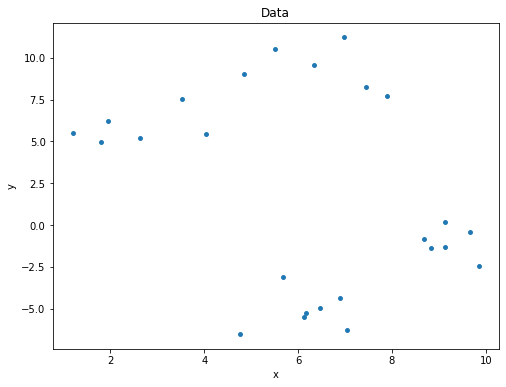

In [ ]:
# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
X, y = make_blobs(n_samples=number_of_points, centers=number_of_groups, shuffle=False, random_state=13)
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.scatter(X[:,0],X[:,1],marker='o',s=15)
ax1.set(xlabel='x',ylabel='y',title='Data')
#fig.set_facecolor("#6C7B8B")
#fig.savefig('initial_data.png')
# Make blobs
'''
C1 = np.append([-2, 2] + 0.4 * np.random.randn(n_points_per_cluster, 2), axis=0)
C1=C1[1:,:]
print(C1.shape)
X = np.vstack((C1))
'''


The simplest Hamiltonian for clustering can be written as
$$H=\sum_{g=1}^G \sum_{i<j} d_{ij} x_{i,g} x_{j,g} + \alpha \sum_{i=1}^N \left( \sum_{g=1}^G x_{i,g} - 1 \right)^2 $$. To turn this into an ising problem, we must write $x_{i,g} = \frac{1-s_{i,g}}{2}$. Therefore, the Hamiltonian written in terms of ising spins becomes $$
  H=\sum_{g=1}^G \left[\sum_{i<j} d_{ij} \left( \frac{1-s_{i,g}}{2} \right) \left( \frac{1-s_{i,g}}{2} \right) \right] + \alpha \sum_{i=1}^N \left[ \left(\sum_{g=1}^G \frac{1-s_{i,g}}{2} \right) - 1 \right]^2 $$



In [ ]:
# Make Edges for Distance Computing
edges=[]
for i in range(number_of_points):
  for j in range(i,number_of_points):
    if i!=j and (j,i) not in edges:
      edges.append((i,j))
    else:
      continue

# Calculate Distances Between Points
distances=[]
for i,j in edges:
  distances.append(np.sqrt((X[i,0]-X[j,0])**2+(X[i,1]-X[j,1])**2))
distances_norm= (distances)/(np.max(distances))


In [ ]:
from docplex.mp.solution import SolutionPool

# Begin implementation of CPLEX
start = time.time()
model=md.Model(name='Clustering')

# Set the spin number and second prameter g (number of groups)
x=model.binary_var_list(number_of_points*number_of_groups)
s=np.array(x).reshape(number_of_points,number_of_groups)

# Create Hamiltonians
H1 = np.sum([ distances_norm[edges.index((i,j))]*s[i,k]*s[j,k]  for i,j in edges for k in range(number_of_groups)])
H2 = np.sum([ [ (np.sum(s[i,:])-1)**2 ] for i in range(number_of_points)])

# Set up Hamiltonian
model.minimize(H1+H2)
si = model.solve(url=None,key=None)
a=np.array(model.solution.get_value_list(x),dtype=int).reshape(number_of_points,number_of_groups)
a=model.solution.get_value_list(x)
a=np.array(a,dtype=int)
solution=np.array(a).reshape(number_of_points,number_of_groups)
time_cplex=time.time()-start

# Brute force pull groups
groups_cplex=[]
for i in range(number_of_points): 
  # Collect outliers by setting them to out of bounds group number
  if np.sum(solution[i])==0:
    groups_cplex.append(number_of_groups)
  # Otherwise, add the group index
  else:
    for j in range(number_of_groups):
      if solution[i,j]==1:
        groups_cplex.append(j)
      else:
        continue

# Misses zeroth solutions
# Pull values from index 1 (group numbers) sorting along index 0 (points)
# np.where(sol)[0] tells you which group index (which row) and np.where(sol)[1] 
# tells you the index of the points (+1) in the solution array for that row
#
#groups=np.vstack((np.where(solution)[0],np.where(solution)[1]))  
#groups=groups[1,groups[0].argsort()] 
#

print('Solution: ', groups_cplex)
print('Total Time:' , time_cplex,'s')



Solution:  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3]
Total Time: 6.969762325286865 s


In [ ]:
# Create spins using pyqubo 
x=Array.create('s', shape=(number_of_points,number_of_groups), vartype='SPIN')
x=(x+1)/2

# Compute Hamiltonian
# Create Hamiltonians
H1 = np.sum([ distances_norm[edges.index((i,j))]*x[i,k]*x[j,k]  for i,j in edges for k in range(number_of_groups)])
H2 = np.sum([ [ (np.sum(x[i,:])-1)**2 ] for i in range(number_of_points)])
H=H1+H2
model=H.compile()

# Solve qubo
qubo, offset = model.to_qubo()
sampler = neal.SimulatedAnnealingSampler()
bqm = model.to_bqm()
sampleset = sampler.sample(bqm, num_reads=300)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)
#sol= best_sample.sample  // doing in below
solution=np.array([ [best_sample.sample.get('s['+str(i)+']['+str(j)+']') for i in range(number_of_points)] for j in range(number_of_groups) ])
#solution=np.array(sol) //  doing in above

# Brute force pull groups
groups_pyqubo=[]
for i in range(number_of_points): 
  # Collect outliers by setting them to out of bounds group number
  if np.sum(solution[:,i])==0:
      groups_pyqubo.append(number_of_groups)
  # Otherwise, add the group index
  else:
    for j in range(number_of_groups):
      if solution[j,i]==1:
        groups_pyqubo.append(j)
      else:
        continue

# np.where(sol)[0] tells you which group index (which row) and np.where(sol)[1] 
# tells you the index of the points (+1) in the solution array for that row
# labels each point (at each index) with its group number
#
#sol=np.vstack((np.where(sol)[0],np.where(sol)[1])) 
#sol=sol[0,sol[1].argsort()] 
#
print('Solution: ', groups_pyqubo)

Solution:  [3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


[Text(0, 0.5, 'y'), Text(0.5, 0, 'x'), Text(0.5, 1.0, 'PyQUBO Clustering')]

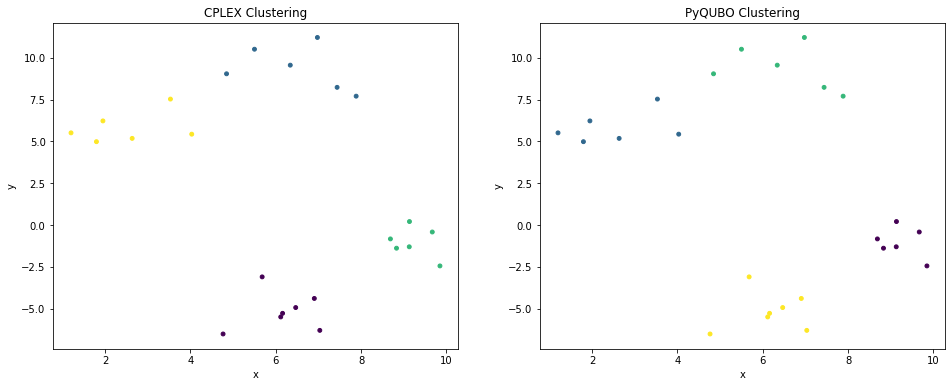

In [ ]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(16,6))
ax2.scatter(X[:,0],X[:,1],marker='o',s=15,c=groups,cmap=plt.cm.viridis)
ax2.set(xlabel='x',ylabel='y',title='CPLEX Clustering')
ax3.scatter(X[:,0],X[:,1],marker='o',s=15,c=groups_pyqubo,cmap=plt.cm.viridis)
ax3.set(xlabel='x',ylabel='y',title='PyQUBO Clustering')